<a href="https://colab.research.google.com/github/lakhanrajpatlolla/aiml-learning/blob/master/Another_copy_of_Group_12_U3_MH2_Plant_Images_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## Problem Statement

Denoise the leaf images using deep learning techniques

## Learning Objectives

At the end of the Mini Hackathon, you will be able to :
* Denoise healthy/diseased leaf images using Autoencoder
* Visualize the denoised images

In [ ]:
#@title Mini Hackathon Walkthrough Video
from IPython.display import HTML

HTML("""<video width="500" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint1/archives/sc/misc/M3_Mini_Hackathon1_Plant_Images_Denoising.mp4" type="video/mp4">
</video>
""")

## Background

Crop losses due to diseases are a major threat to food security every year, across countries.  Conventionally, plant diseases were detected through a visual examination of the affected plants by plant pathology experts. This was often possible only after major damage had already occurred, so treatments were of limited or no use. Recently, access to smartphone based image capturing has highly increased amongst farmers and agriculturists. This has led to the successful adoption of plant disease diagnostic applications based on deep learning techniques. This is of immense value in the field of agriculture and an excellent tool for faster identification and treatment of crop diseases. It holds key importance in preventing crop based food and economic losses.
## Dataset and Methodology

The dataset for this Mini-Hackathon is derived from the 'Plant Village' Dataset.Around 4500 images of healthy and diseased leaves and their labels have been taken from the 'Plant Village' Dataset. The 4500 images consist of 5 different classes - Bell Pepper Healthy, Bell Pepper Bacterial Spot, Potato Healthy, Potato Early Blight and Potato Late Blight. The original pictures have been clicked in a well controlled environment with very less noise in the images. This is not how real world data may look like.  So we have added noise to the original images to form a noisy dataset. We can use deep learning techniques such as an autoencoder for obtaining denoised images.


## References:

[Plant Village Dataset Description](https://drive.google.com/file/d/1xGhK-KhhE8W_lfr3l6KT_9K8prHDRb9_/view?usp=sharing)


[Deep Learning for Plant Disease Detection](https://drive.google.com/file/d/1V7NgFs-YGG3G-pz3OJf2X-KQxOGRZzRu/view?usp=sharing)

[Autoencoder motivational Expt](https://colab.research.google.com/drive/1gkxGlPQ5F3PtugI_zKMeFl3fYVOmscxk?authuser=1#scrollTo=Yv3ZC8aOKJqL)


## Grading = 10 Marks

## Setup Steps

In [ ]:
#@title Run this cell to download the dataset

from IPython import get_ipython
ipython = get_ipython()

notebook="M3_Mini_Hackathon1_Plant_Images_Denoising" #name of the notebook
Answer = "This notebook is graded by mentors on the day of hackathon"
def setup():
   ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/PlantVillage_Noisy_Dataset.zip")
   ipython.magic("sx unzip -qq PlantVillage_Noisy_Dataset.zip")
   print ("Setup completed successfully")
   return

setup()

Setup completed successfully


**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

## **Stage 1:** Data Preparation

### 1 Marks - > Prepare the dataset

1. Define transformations:
   * Transform image size to 128 by using Resize()
   * Transform the image into a number using tensor
2. Load the dataset with the defined transformations.

In [ ]:
# YOUR CODE HERE for the transforming the dataset
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class DenoisePlantDataset(Dataset):
  def __init__(self, noisy_dir, pure_dir, transform=None):
    self.noisy_dir = noisy_dir
    self.pure_dir = pure_dir
    self.transform = transform

    self.image_paths = []
    plant_folders = os.listdir(noisy_dir)
    for plant in plant_folders:
      plant_noisy_path = os.path.join(noisy_dir, plant)
      plant_pure_path = os.path.join(pure_dir, plant)

      noisy_images = sorted(os.listdir(plant_noisy_path))
      pure_images = sorted(os.listdir(plant_pure_path))

      for noisy_image, pure_image in zip(noisy_images, pure_images):
        self.image_paths.append((os.path.join(plant_noisy_path, noisy_image), os.path.join(plant_pure_path, pure_image), noisy_image))

  def __len__(self):
    return len(self.image_paths)


  def __getitem__(self, idx):
    noisy_path, pure_path, image_name = self.image_paths[idx]

    noisy_image = Image.open(noisy_path).convert("RGB")
    pure_image = Image.open(pure_path).convert("RGB")

    if self.transform:
      noisy_image = self.transform(noisy_image)
      pure_image = self.transform(pure_image)

    return noisy_image, pure_image, image_name

In [ ]:
# YOUR CODE HERE for preparing trainloader and testloader set
train_noisy_path = '/content/PlantVillage/Noisy_Dataset/Train_Data'
train_pure_path = '/content/PlantVillage/Pure_Dataset/Train_Data'
test_noisy_path = '/content/PlantVillage/Noisy_Dataset/Test_Data'
test_pure_path = '/content/PlantVillage/Pure_Dataset/Test_Data'

train_set = DenoisePlantDataset(train_noisy_path, train_pure_path, transform=transform)
test_set = DenoisePlantDataset(test_noisy_path, test_pure_path, transform=transform)

In [ ]:
# from torch.utils.data import random_split
# import numpy as np

# validation_size = 0.07

# n_validation = int(np.floor(validation_size*len(train_set)))
# n_train = len(train_set) - n_validation

# train_data, validation_data = random_split(train_set, [n_train, n_validation])

In [ ]:
# !rm -rf /content/OutputImages

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

## **Stage 2:** Build and Train the Model



### 2 Marks -> Write the encoder and decoder layers in one class

* Define the Autoencoder neural network
    *  First define the layers required in the  __init__ function.
    *  Build the neural network in the forward() function.

[Hint for saving the images](https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/)

In [ ]:
# YOUR CODE HERE for defining a function for creating the directory
from torchvision.utils import save_image

def make_dir():
    image_dir = '/content/OutputImages'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch, image_names):
  #save each image in the img tensor with corresponding image name in image_names
  for i in range(img.size(0)):
    img_name = image_names[i]
    #save image
    save_image(img[i], '/content/OutputImages/{}_{}'.format(epoch, img_name))



    # img = img.view(img.size(0), 3, 128, 128)
    # save_image(img, '/content/OutputImages/{}.png'.format(epoch))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out


In [ ]:
# YOUR CODE HERE for constructing an autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.2),
        )

        # Decoder
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): Sigmoid()
  )
)


### 2 Marks -> Train the Model and calculate the loss for dataset for each epoch.

1. Declare the loss function and optimizer
2. Create a directory for saving the output images.
2. Train the model
   *  Extract the image features only as we do not take the labels to train the autoencoder network.
   * Calculate the loss.
   * Append the loss values after every epoch and print them.
   * Save the output (denoised) images in a directory.

In [ ]:
# YOUR CODE HERE for declaring the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# YOUR CODE HERE.

# Train the model and print the loss at each epoch. Also save the output (denoised) images in a directory.
number_of_epochs = 15
make_dir()
train_losses = []

model = model.to(device)

model.train()

for e in range(number_of_epochs):
    print('Epoch {}/{}'.format(e+1, number_of_epochs))
    train_loss = 0

    # Iterate through all the batches in each epoch
    for noisy_image, pure_image, image_name in train_loader:

      # Convert the image and label to gpu for faster execution
      noisy_image = noisy_image.to(device)
      pure_image = pure_image.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Passing the data to the model (Forward Pass)
      denoised_image = model(noisy_image)

      if((e+1) % 10 == 0 or e+1==number_of_epochs):
        save_decoded_image(denoised_image, e+1, image_name)

      # Calculating the loss
      # print(denoised_image.shape)
      # print(pure_image.shape)
      loss = criterion(denoised_image, pure_image)
      train_loss += loss.item()

      # Performing backward pass (Backpropagation)
      loss.backward()

      # optimizer.step() updates the weights accordingly
      optimizer.step()

    train_losses.append(train_loss)
    print('Epoch: {}, Loss: {:.2f} '.format(e+1, train_loss))

Epoch 1/15
Epoch: 1, Loss: 0.77 
Epoch 2/15
Epoch: 2, Loss: 0.28 
Epoch 3/15
Epoch: 3, Loss: 0.24 
Epoch 4/15
Epoch: 4, Loss: 0.22 
Epoch 5/15
Epoch: 5, Loss: 0.21 
Epoch 6/15
Epoch: 6, Loss: 0.21 
Epoch 7/15
Epoch: 7, Loss: 0.20 
Epoch 8/15
Epoch: 8, Loss: 0.20 
Epoch 9/15
Epoch: 9, Loss: 0.20 
Epoch 10/15
Epoch: 10, Loss: 0.20 
Epoch 11/15
Epoch: 11, Loss: 0.19 
Epoch 12/15
Epoch: 12, Loss: 0.19 
Epoch 13/15
Epoch: 13, Loss: 0.19 
Epoch 14/15
Epoch: 14, Loss: 0.18 
Epoch 15/15
Epoch: 15, Loss: 0.18 


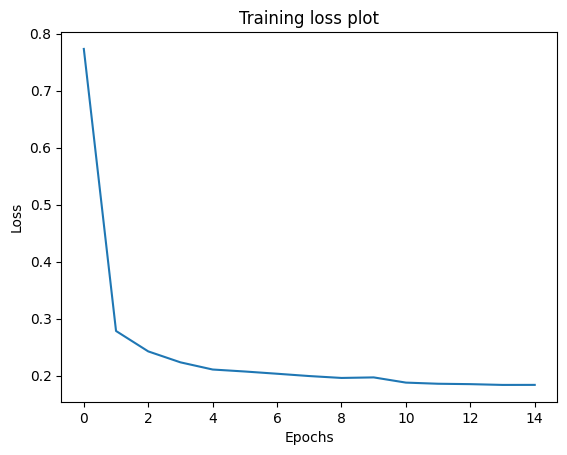

In [ ]:
#plot the train_loss
plt.plot(train_losses)
plt.title("Training loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## **Stage 3:** Visualize the Denoised images

### 2 Marks -> Verify the denoised images and compare with original noisy images
1. Plot the original noisy images.
2. Plot denoised images which are saved in the directory.
3. Verify whether denoised images have less noise compared to original noisy images

**Hint:** If the noise is not reduced in the denoised images then revise the autoencoder architecture.

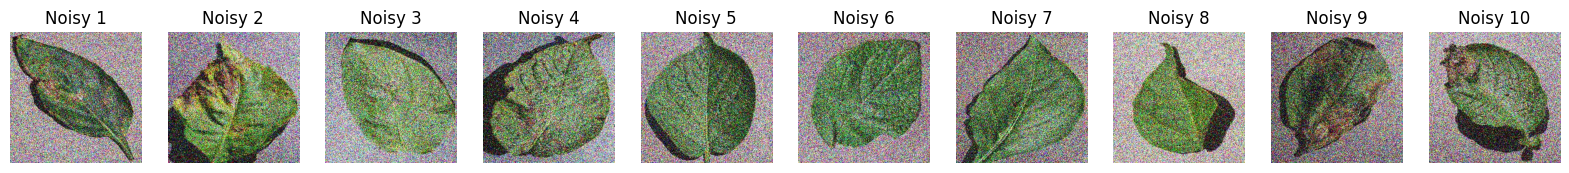

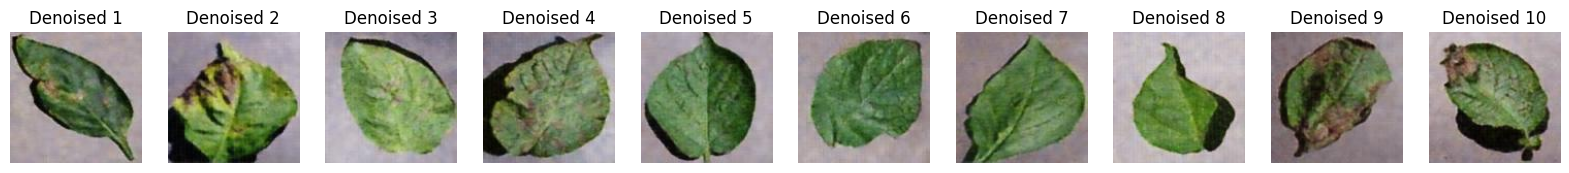

In [ ]:
# YOUR CODE HERE for plotting and verifying the images (original noisy images and denoising images)

# Select 10 files from the noisy samples, record the name of the files so that I can fetch the corresponding files from OutputImages folder

import random
import matplotlib.image as mpimg

# Select 2 images from each of the folders in /content/PlantVillage/Noisy_Dataset/Train_Data/
selected_images = []
selected_image_names = []
for folder_name in os.listdir('/content/PlantVillage/Noisy_Dataset/Train_Data'):
  folder_path = os.path.join('/content/PlantVillage/Noisy_Dataset/Train_Data', folder_name)
  if os.path.isdir(folder_path):
            image_files = os.listdir(folder_path)
            # Randomly select images from the folder
            selected_image_files = random.sample(image_files, 2)
            selected_image_paths = [os.path.join(folder_path, image_file) for image_file in selected_image_files]
            # add selected image paths in selected_images
            selected_images.extend(selected_image_paths)
            selected_image_names.extend(selected_image_files)

# plot the images in selected_images horizontally, make the image size smaller
plt.figure(figsize=(20, 20))
for i, image_path in enumerate(selected_images):
  img = mpimg.imread(image_path)
  plt.subplot(1, len(selected_images), i+1)
  plt.imshow(img)
  plt.title(f"Noisy {i+1}")
  plt.axis('off')

# plot the images from OutputImages folder just under the above images

plt.figure(figsize=(20, 20))
for i, image_name in enumerate(selected_image_names):
  img_path = f'/content/OutputImages/{number_of_epochs}_{image_name}'
  img = mpimg.imread(img_path)
  plt.subplot(1, len(selected_image_names), i+1)
  plt.imshow(img)
  plt.title(f"Denoised {i+1}")
  plt.axis('off')


## **Stage 4:** Test the Model

### 2 Marks -> Evaluate model with the given test data

1. Extract only the images of test loader data as we do not use the labels for the autoencoder network
2. Pass the test images through the autoencoder model to get the denoised images of the test data.
3. Calculate the loss of the test images

In [ ]:
# YOUR CODE HERE for recording the loss of the test dataset
model.eval()

test_loss = 0
with torch.no_grad():
    for noisy_image, pure_image, image_name in test_loader:
        noisy_image = noisy_image.to(device)
        pure_image = pure_image.to(device)

        denoised_image = model(noisy_image)

        loss = criterion(denoised_image, pure_image)
        test_loss += loss.item()
        save_decoded_image(denoised_image, 'test', image_name)

print('Test Loss: {:.2f}'.format(test_loss))


Test Loss: 0.08


### 1 Marks -> Visualizing and verifying test images with the original test noisy dataset

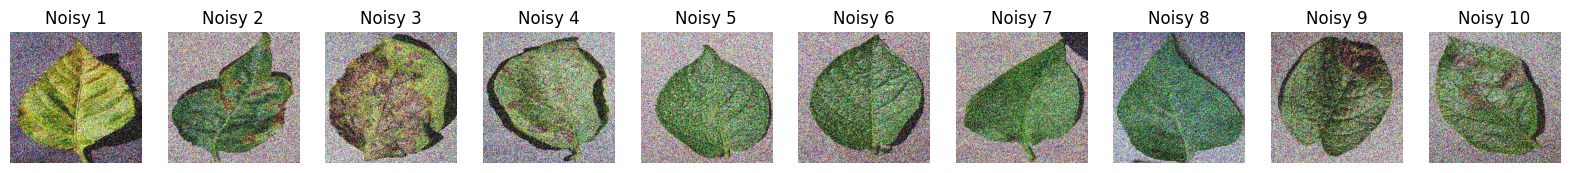

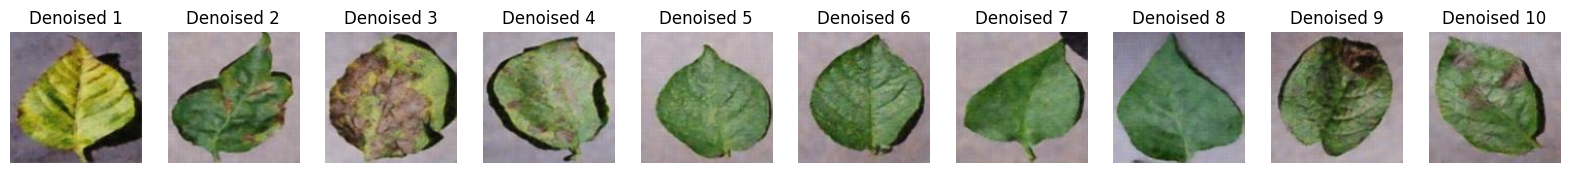

In [ ]:
# YOUR CODE HERE for verification and visualization of the test denoised images and original test noisy images
selected_images = []
selected_image_names = []
for folder_name in os.listdir('/content/PlantVillage/Noisy_Dataset/Test_Data'):
  folder_path = os.path.join('/content/PlantVillage/Noisy_Dataset/Test_Data', folder_name)
  if os.path.isdir(folder_path):
            image_files = os.listdir(folder_path)
            # Randomly select images from the folder
            selected_image_files = random.sample(image_files, 2)
            selected_image_paths = [os.path.join(folder_path, image_file) for image_file in selected_image_files]
            # add selected image paths in selected_images
            selected_images.extend(selected_image_paths)
            selected_image_names.extend(selected_image_files)

# plot the images in selected_images horizontally, make the image size smaller
plt.figure(figsize=(20, 20))
for i, image_path in enumerate(selected_images):
  img = mpimg.imread(image_path)
  plt.subplot(1, len(selected_images), i+1)
  plt.imshow(img)
  plt.title(f"Noisy {i+1}")
  plt.axis('off')

# plot the images from OutputImages folder just under the above images

plt.figure(figsize=(20, 20))
for i, image_name in enumerate(selected_image_names):
  img_path = f'/content/OutputImages/test_{image_name}'
  img = mpimg.imread(img_path)
  plt.subplot(1, len(selected_image_names), i+1)
  plt.imshow(img)
  plt.title(f"Denoised {i+1}")
  plt.axis('off')
